In [2]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

## Generate Data

$p(x, y) = N(\mu_x = 0, \mu_y = 0, \sigma_x = 1, \sigma_y = 1, r = 0.5)$

$p(x_{obs}, y_{obs}|x, y) = N(\mu_x = x, \mu_y = y, \sigma_x = 1, \sigma_y = 1, r = 0)$

In [3]:
x, y = multivariate_normal(mean=[0, 0], cov=[[1, 0.5], [0.5, 1]]).rvs(1000).T

(-4.0, 4.0)

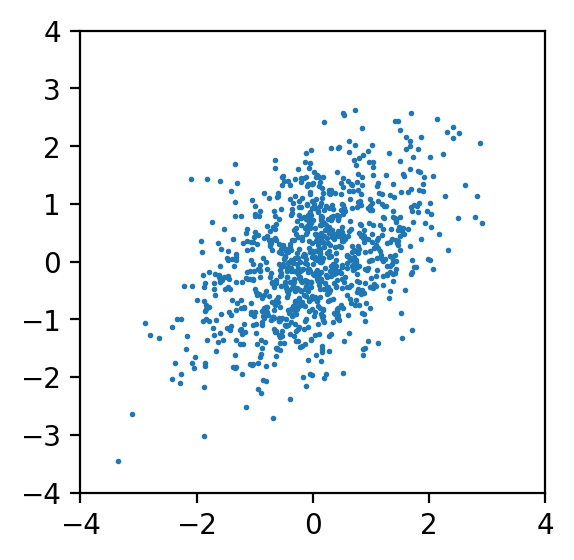

In [4]:
plt.figure(figsize=(3, 3), dpi=200)
plt.scatter(x, y, s=1)
plt.xlim(-4, 4)
plt.ylim(-4, 4)

In [5]:
# estimate the mean and covariance of the data
mean = np.mean([x, y], axis=1)
cov = np.cov([x, y])
mean, cov

(array([0.01597465, 0.01793009]),
 array([[0.95941173, 0.43921252],
        [0.43921252, 0.92293863]]))

In [6]:
# generate x_obs, y_obs
x_obs = np.zeros_like(x)
y_obs = np.zeros_like(y)
for i, (xi, yi) in enumerate(zip(x, y)):
    x_obs[i], y_obs[i] = multivariate_normal(mean=[xi, yi], cov=[[1, 0], [0, 1]]).rvs(1).T

(-5.0, 5.0)

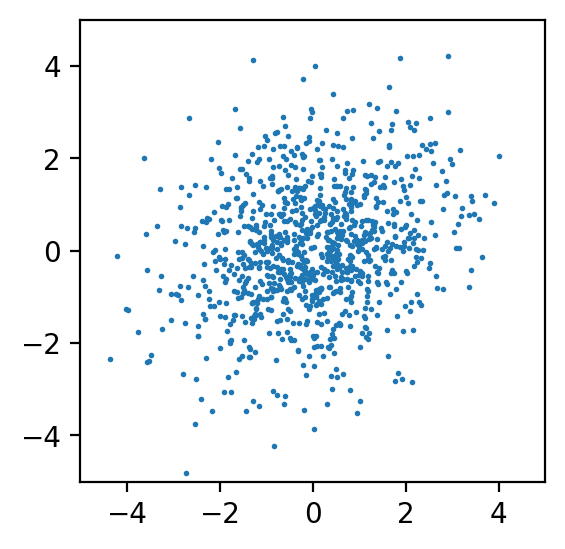

In [7]:
plt.figure(figsize=(3, 3), dpi=200)
plt.scatter(x_obs, y_obs, s=1)
plt.xlim(-5, 5)
plt.ylim(-5, 5)

In [8]:
mean = np.mean([x_obs, y_obs], axis=1)
cov = np.cov([x_obs, y_obs])
mean, cov

(array([-0.00872065,  0.05203218]),
 array([[2.01224059, 0.43486931],
        [0.43486931, 1.82320091]]))

## Inference

$$
q(x, y|x_{obs}, y_{obs}) = \frac{p(x_{obs}, y_{obs}|x, y)q(x, y)}{q(x_{obs}, y_{obs})} = N(\mu', \Sigma')
$$

https://math.stackexchange.com/questions/157172/product-of-two-multivariate-gaussians-distributions

In [9]:
def get_posterior(x_obs, y_obs, mean_prior, cov_prior):
    # calculate the parameter of posterior distribution
    cov1 = np.array([[1, 0], [0, 1]])
    mean1 = np.array([x_obs, y_obs])
    cov2 = np.asarray(cov_prior)
    mean2 = np.asarray(mean_prior)
    S1S2_inv = np.linalg.inv(cov1 + cov2)
    _mean = cov2 @ S1S2_inv @ mean1 + cov1 @ S1S2_inv @ mean2
    _cov = cov1 @ S1S2_inv @ cov2
    return _mean, _cov

In [10]:
def one_step(x_obs, y_obs, mean, cov, N=100):
    mean_post_list = []
    cov_post_list = []

    for x_obs_i, y_obs_i in zip(x_obs, y_obs):
        _mean, _cov = get_posterior(x_obs_i, y_obs_i, mean, cov)
        mean_post_list.append(_mean)
        cov_post_list.append(_cov)

    x_post_all = np.zeros((x.shape[0], N))
    y_post_all = np.zeros((y.shape[0], N))

    for i, (_mean, _cov) in enumerate(zip(mean_post_list, cov_post_list)):
        x_post_all[i], y_post_all[i] = multivariate_normal(mean=_mean,
                                                        cov=_cov).rvs(N).T

    x_post_all = x_post_all.flatten()
    y_post_all = y_post_all.flatten()

    mean_new = np.mean([x_post_all, y_post_all], axis=1)
    cov_new = np.cov([x_post_all, y_post_all])

    return mean_new, cov_new

In [11]:
_mean, _cov = one_step(x_obs, y_obs, [0, 0], [[1, 0.5], [0.5, 1]], N=100)
_mean, _cov

(array([0.00439631, 0.02688894]),
 array([[0.98951341, 0.47063948],
        [0.47063948, 0.95020323]]))

In [12]:
mean_0 = [0, 0]
cov_0 = [[0.5, 0], [0, 0.5]]

_mean = mean_0
_cov = cov_0
for i in range(20):
    _mean, _cov = one_step(x_obs, y_obs, _mean, _cov, N=100)
    if i % 5 == 0:
        print('-----')
        print(i)
        print(_mean)
        print(_cov)

print('-----')
print('final')
print(_mean)
print(_cov)

-----
0
[-0.00279791  0.01888865]
[[0.5520782  0.0489517 ]
 [0.0489517  0.53592694]]
-----
5
[-0.00705336  0.04552195]
[[0.86108691 0.30570435]
 [0.30570435 0.72648733]]
-----
10
[-0.00583088  0.05293854]
[[0.9821441  0.40639128]
 [0.40639128 0.80684401]]
-----
15
[-0.00794444  0.05416996]
[[0.99751813 0.42516938]
 [0.42516938 0.81162276]]
-----
final
[-0.00604552  0.04781754]
[[1.00889379 0.43781471]
 [0.43781471 0.81771788]]


In [13]:
mean_post_list_final = []
cov_post_list_final = []

for x_obs_i, y_obs_i in zip(x_obs, y_obs):
    _mean, _cov = get_posterior(
        x_obs_i, y_obs_i, [-0.01860801, -0.0352255],
        [[1.08898638, 0.4937943], [0.4937943, 0.91520897]])
    mean_post_list_final.append(_mean)
    cov_post_list_final.append(_cov)

In [14]:
mean_post_list_0 = []
cov_post_list_0 = []

for x_obs_i, y_obs_i in zip(x_obs, y_obs):
    _mean, _cov = get_posterior(x_obs_i, y_obs_i, mean_0, cov_0)
    mean_post_list_0.append(_mean)
    cov_post_list_0.append(_cov)

(0.6782427367302023, 0.7272664117449916)

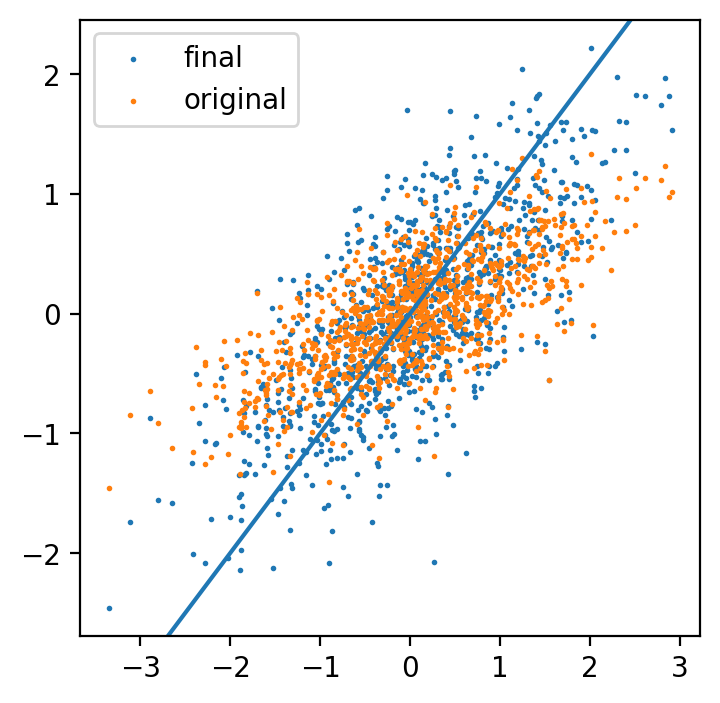

In [15]:
plt.figure(figsize=(4, 4), dpi=200)
plt.scatter(x, np.array(mean_post_list_final)[:, 0], s=1, label='final')
plt.scatter(x, np.array(mean_post_list_0)[:, 0], s=1, label='original')
plt.axline([0, 0], [1, 1])
plt.legend()

np.std(np.array(mean_post_list_final)[:, 0] - x), np.std(np.array(mean_post_list_0)[:, 0] - x)